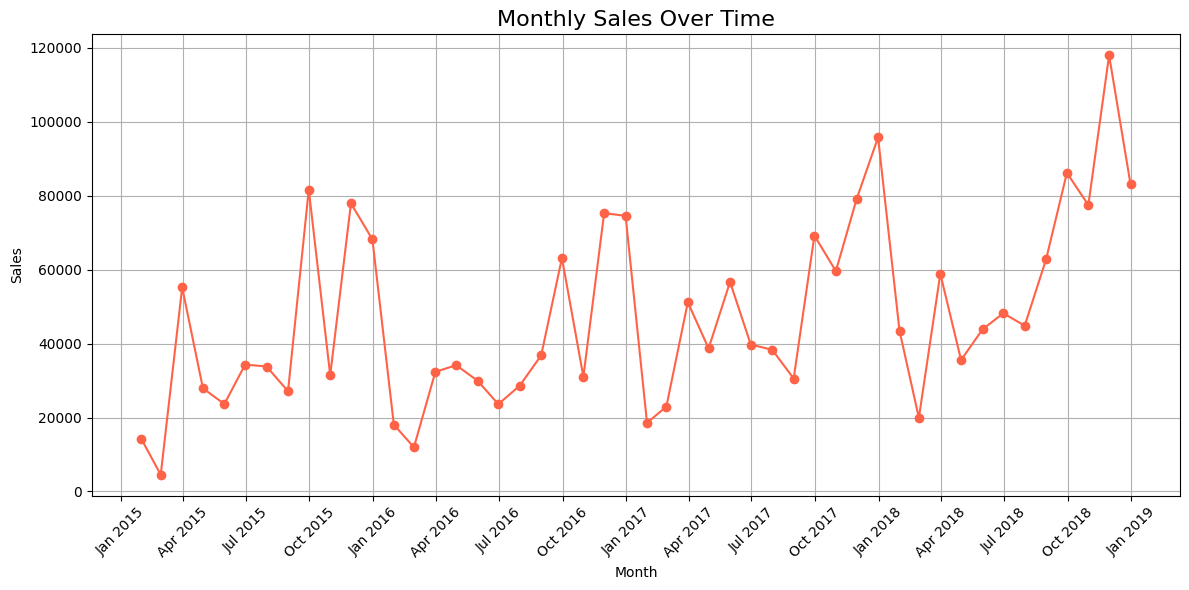

In [ ]:
# 🧠 Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 📥 Load Data
df = pd.read_csv('/content/train.csv')  # Rename if different

# 🧼 Clean it
df = df[['Order Date', 'Sales']]  # Keep only needed columns

# 🗓️ Convert to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

# 📆 Set date as index & sort
df = df.sort_values('Order Date')
df.set_index('Order Date', inplace=True)

# 🔁 Resample Monthly
monthly_sales = df['Sales'].resample('ME').sum()

# 📊 Visualize
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', color='tomato')
plt.title('Monthly Sales Over Time', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)

# ⏱ Format the x-axis to show every 3rd month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0jn2omp/9xuca84p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0jn2omp/eru9u3j7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10934', 'data', 'file=/tmp/tmpj0jn2omp/9xuca84p.json', 'init=/tmp/tmpj0jn2omp/eru9u3j7.json', 'output', 'file=/tmp/tmpj0jn2omp/prophet_modelb86dt5zm/prophet_model-20250626101824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

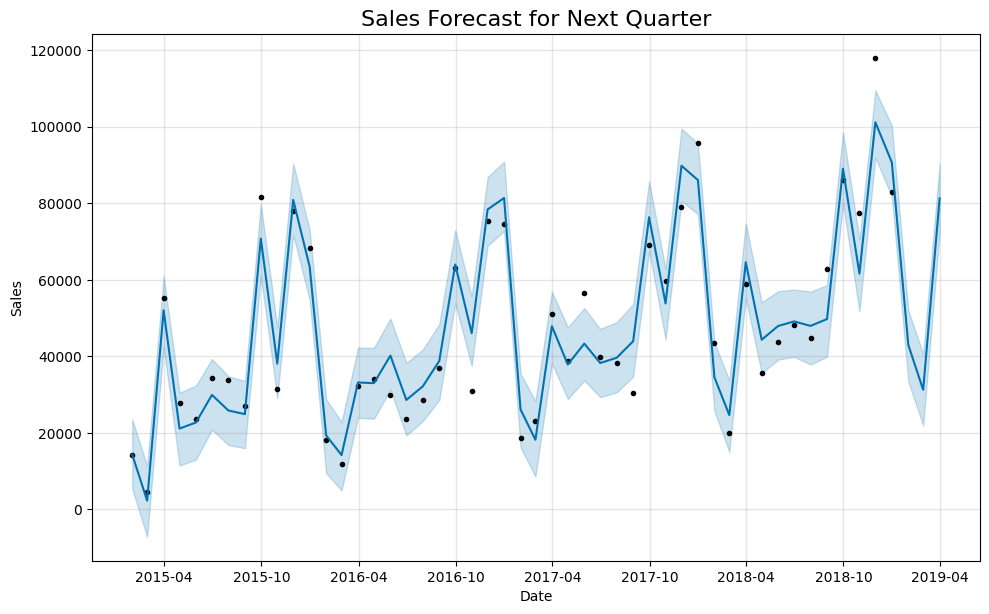

In [ ]:
# 📦 Install Prophet (if not already installed)
#!pip install prophet

# 🧠 Imports
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# 🔁 Prepare Data for Prophet
# Use the already resampled monthly_sales series
df_prophet = monthly_sales.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet needs these exact column names

# 🔮 Initialize & Fit Model
model = Prophet()
model.fit(df_prophet)

# 🕰️ Make future dataframe: next 3 months
future = model.make_future_dataframe(periods=3, freq='M')

# 📈 Predict!
forecast = model.predict(future)

# 🎨 Plot it!
fig = model.plot(forecast)
plt.title("Sales Forecast for Next Quarter", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [ ]:
from prophet import Prophet
import pandas as pd
import plotly.graph_objects as go

# Prepare data
df_prophet = monthly_sales.reset_index()
df_prophet.columns = ['ds', 'y']

# Fit Prophet
model = Prophet()
model.fit(df_prophet)

# Forecast future
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Resample both actual and forecast
def resample_both(label, freq):
    actual = df_prophet.set_index('ds').resample(freq).mean().reset_index()
    actual['type'] = label

    forecast_grouped = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').resample(freq).mean().reset_index()
    forecast_grouped['type'] = label

    return actual, forecast_grouped

# Create all views
actual_m, forecast_m = df_prophet.assign(type='Monthly'), forecast.assign(type='Monthly')
actual_q, forecast_q = resample_both('Quarterly', '3M')
actual_h, forecast_h = resample_both('Half-Yearly', '6M')
actual_y, forecast_y = resample_both('Yearly', 'Y')

# Plot
fig = go.Figure()

def add_trace_set(label, actual_df, forecast_df, visible):
    # Actual
    fig.add_trace(go.Scatter(
        x=actual_df['ds'], y=actual_df['y'], mode='markers', name=f'{label} Actual',
        marker=dict(color='black'), visible=visible
    ))
    # Forecast line
    fig.add_trace(go.Scatter(
        x=forecast_df['ds'], y=forecast_df['yhat'], mode='lines', name=f'{label} Forecast',
        visible=visible
    ))
    # Confidence band
    fig.add_trace(go.Scatter(
        x=pd.concat([forecast_df['ds'], forecast_df['ds'][::-1]]),
        y=pd.concat([forecast_df['yhat_upper'], forecast_df['yhat_lower'][::-1]]),
        fill='toself',
        fillcolor='rgba(0,123,255,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False,
        visible=visible
    ))

# Add all views (only monthly is visible by default)
add_trace_set('Monthly', actual_m, forecast_m, True)
add_trace_set('Quarterly', actual_q, forecast_q, False)
add_trace_set('Half-Yearly', actual_h, forecast_h, False)
add_trace_set('Yearly', actual_y, forecast_y, False)

# Dropdown
fig.update_layout(
    title='             Interactive Forecast (Actual + Prediction Toggle)',
    xaxis_title='Date',
    yaxis_title='Sales',
    updatemenus=[dict(
        buttons=[
            dict(label='Monthly', method='update',
                 args=[{'visible': [True, True, True, False, False, False, False, False, False, False, False, False]}]),
            dict(label='Quarterly', method='update',
                 args=[{'visible': [False, False, False, True, True, True, False, False, False, False, False, False]}]),
            dict(label='Half-Yearly', method='update',
                 args=[{'visible': [False, False, False, False, False, False, True, True, True, False, False, False]}]),
            dict(label='Yearly', method='update',
                 args=[{'visible': [False, False, False, False, False, False, False, False, False, True, True, True]}]),
        ],
        direction='down',
        x=0.1,
        y=1.2
    )]
)

fig.show()


NameError: name 'monthly_sales' is not defined

In [ ]:
# Rename actuals
actual = df_prophet.rename(columns={
    'ds': 'Date',
    'y': 'Actual_Sales'
})

# Rename forecast outputs
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'ds': 'Date',
    'yhat': 'F_Forecast',
    'yhat_lower': 'F_Lower',
    'yhat_upper': 'F_Upper'
})

# Merge actual + forecast
merged = pd.merge(actual, forecast_df, on='Date', how='outer').sort_values('Date')

# Export as clean CSV
merged.to_csv('clean_forecast_dashboard.csv', index=False)
